In [2]:
# Main imports
import curiosidade
import torch
import torch.nn


# Example imports
import functools

import numpy as np
import torch.nn.functional as F
import sentence_transformers
import datasets
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

/media/nvme/probing/ulysses-curiosity/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To probe [SentenceTransformers](https://www.sbert.net/) with Curiosity, you have two options:
- a) Get the transformer and tokenizer submodules from the SentenceTransformer; or
- b) Probe directly the SentenceTransformer model.

The first option provides a similar setup for regular BERT models, whereas the the second option may be simpler to setup in case you SentenceTransformer is composed of various SentenceTransformers submodules (such as [LaBSE](https://huggingface.co/sentence-transformers/LaBSE)).

**Table of Contents**
1. [BERT-like setup](#BERT-like-setup)
    1. [Setup pretrained model (BERT-like)](#Setup-pretrained-model-(BERT-like))
	2. [Setup probing tasks](#Setup-probing-tasks)
		1. [Set up probing dataset for SentLen task](#Set-up-probing-dataset-for-SentLen-task)
		2. [Set up probing model architecture](#Set-up-probing-model-architecture)
		3. [Set up probing task](#Set-up-probing-task)
		4. [Train probing model](#Train-probing-model)
	3. [Analyzing results](#Analyzing-results)
2. [Setup pretrained model (with SentenceTransformers)](#Setup-pretrained-model-(with-SentenceTransformers))

# BERT-like setup

## Setup pretrained model (BERT-like)

In [2]:
minilm = sentence_transformers.SentenceTransformer(
    "paraphrase-MiniLM-L6-v2",
    cache_folder="cache",
    device="cpu",
)

tokenizer = minilm.tokenizer
bert = minilm.get_submodule("0")

In [3]:
[name for name, _ in bert.named_modules() if name]

['auto_model',
 'auto_model.embeddings',
 'auto_model.embeddings.word_embeddings',
 'auto_model.embeddings.position_embeddings',
 'auto_model.embeddings.token_type_embeddings',
 'auto_model.embeddings.LayerNorm',
 'auto_model.embeddings.dropout',
 'auto_model.encoder',
 'auto_model.encoder.layer',
 'auto_model.encoder.layer.0',
 'auto_model.encoder.layer.0.attention',
 'auto_model.encoder.layer.0.attention.self',
 'auto_model.encoder.layer.0.attention.self.query',
 'auto_model.encoder.layer.0.attention.self.key',
 'auto_model.encoder.layer.0.attention.self.value',
 'auto_model.encoder.layer.0.attention.self.dropout',
 'auto_model.encoder.layer.0.attention.output',
 'auto_model.encoder.layer.0.attention.output.dense',
 'auto_model.encoder.layer.0.attention.output.LayerNorm',
 'auto_model.encoder.layer.0.attention.output.dropout',
 'auto_model.encoder.layer.0.intermediate',
 'auto_model.encoder.layer.0.intermediate.dense',
 'auto_model.encoder.layer.0.intermediate.intermediate_act_fn',
 

## Setup probing tasks

### Set up probing dataset for SentLen task

In [4]:
dataset_train, dataset_test = datasets.load_dataset("imdb", split=["train", "test"])


def tokenize_fn(item):
    sentlen_label = min(len(tokenizer.encode(item["text"])), 512)
    sentlen_label = float(max(1, np.ceil(sentlen_label / 64) - 1))

    new_item = tokenizer(item["text"], truncation=True, padding="max_length")
    new_item["label"] = sentlen_label

    return new_item


num_classes = 8

dataset_train = dataset_train.shard(num_shards=50, index=0)
dataset_eval = dataset_test.shard(num_shards=50, index=0)
dataset_test = dataset_test.shard(num_shards=50, index=2)

dataset_train = dataset_train.map(tokenize_fn, remove_columns="text")
dataset_eval = dataset_eval.map(tokenize_fn, remove_columns="text")
dataset_test = dataset_test.map(tokenize_fn, remove_columns="text")

dataset_train.set_format("torch")
dataset_eval.set_format("torch")
dataset_test.set_format("torch")

Reusing dataset imdb (/home/felsiq/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 510.01it/s]
Loading cached processed dataset at /home/felsiq/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-cfb833280045c9fe.arrow
Loading cached processed dataset at /home/felsiq/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-1970c26c5361de52.arrow
Loading cached processed dataset at /home/felsiq/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-936fedeae7dd9b74.arrow


In [5]:
probing_dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    dataset_eval,
    batch_size=32,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
)

### Set up probing model architecture

In [6]:
probing_model_fn = curiosidade.probers.utils.get_probing_model_for_sequences(
    hidden_layer_dims=[256, 128],
    pooling_strategy="mean",
)

### Set up probing task

In [10]:
acc_fn = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes).to("cpu")
f1_fn = torchmetrics.classification.MulticlassF1Score(num_classes=num_classes).to("cpu")


def metrics_fn(logits, truth_labels):
    acc = acc_fn(logits, truth_labels).detach().cpu().item()
    f1 = f1_fn(logits, truth_labels).detach().cpu().item()
    return {"accuracy": acc, "f1": f1}


task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    loss_fn=torch.nn.CrossEntropyLoss(),
    task_name="sbert sentlen (example #4)",
    output_dim=num_classes,
    metrics_fn=metrics_fn,
)


optim_fn = functools.partial(torch.optim.Adam, lr=0.05)
lr_scheduler_fn = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.8)

probing_factory = curiosidade.ProbingModelFactory(
    task=task,
    probing_model_fn=probing_model_fn,
    optim_fn=optim_fn,
    lr_scheduler_fn=lr_scheduler_fn,
)

prober_container = curiosidade.core.attach_probers(
    base_model=bert,
    probing_model_factory=probing_factory,
    modules_to_attach="auto_model.encoder.layer.[02]",
    device="cpu",
    prune_unrelated_modules="infer",
)

prober_container

ProbingModelContainer:
(a): Base model: InferencePrunerExtensor(SentenceTransformersAdapter(Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel ))
 | (a): Pruned module(s) (54 in total):
 |   (0): auto_model.encoder.layer.3
 |   (1): auto_model.encoder.layer.3.attention
 |   (2): auto_model.encoder.layer.3.attention.self
 |   (3): auto_model.encoder.layer.3.attention.self.query
 |   (4): auto_model.encoder.layer.3.attention.self.key
 |   (5): auto_model.encoder.layer.3.attention.self.value
 |   (6): auto_model.encoder.layer.3.attention.self.dropout
 |   (7): auto_model.encoder.layer.3.attention.output
 |   (8): auto_model.encoder.layer.3.attention.output.dense
 |   (9): auto_model.encoder.layer.3.attention.output.dropout
 |   (10): auto_model.encoder.layer.3.attention.output.LayerNorm
 |   (11): auto_model.encoder.layer.3.intermediate
 |   (12): auto_model.encoder.layer.3.intermediate.dense
 |   (13): auto_model.encoder.layer.3.output
 |   (14

### Train probing model

In [11]:
probing_results = prober_container.train(
    num_epochs=4,
    show_progress_bar="epoch",
    gradient_accumulation_steps=2,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.61it/s]


## Analyzing results

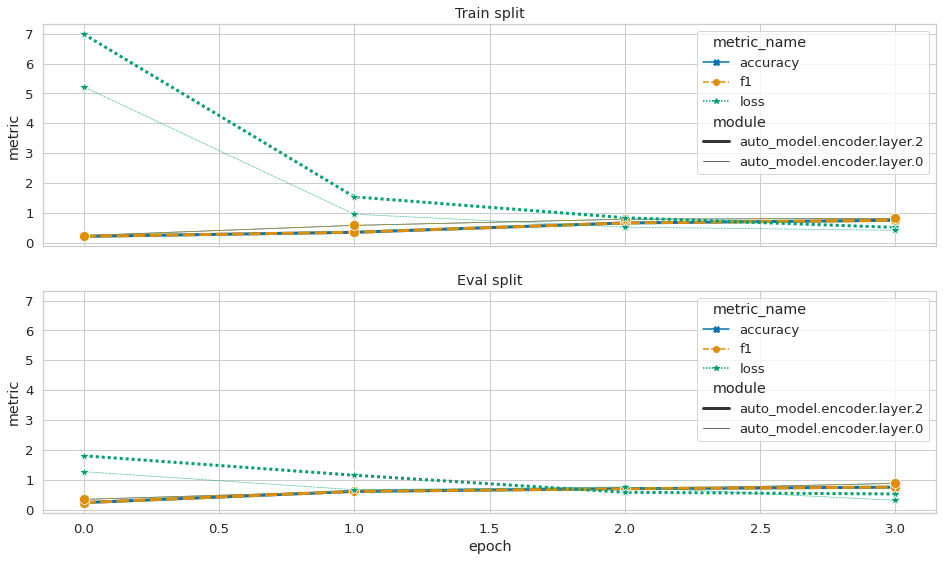

In [12]:
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.2,
    palette="colorblind",
)

fig, (ax_train, ax_eval) = plt.subplots(2, figsize=(16, 9), sharey=True, sharex=True)

df_train, df_eval, df_test = probing_results.to_pandas(aggregate_by=["batch_index"])

common_kwargs = dict(
    hue="metric_name",
    y="metric",
    x="epoch",
    size="module",
    style="metric_name",
    markers=["X", "o", "*"],
    markersize=10,
    size_order=["auto_model.encoder.layer.2", "auto_model.encoder.layer.0"],
)

sns.lineplot(data=df_train, ax=ax_train, **common_kwargs)
sns.lineplot(data=df_eval, ax=ax_eval, **common_kwargs)

ax_train.set_title("Train split")
ax_eval.set_title("Eval split")

plt.show();

In [13]:
df_test

,epoch,metric_name,module,metric
0,-1,accuracy,auto_model.encoder.layer.0,0.897656
1,-1,accuracy,auto_model.encoder.layer.2,0.742969
2,-1,f1,auto_model.encoder.layer.0,0.897656
3,-1,f1,auto_model.encoder.layer.2,0.742969
4,-1,loss,auto_model.encoder.layer.0,0.269697
5,-1,loss,auto_model.encoder.layer.2,0.527696


# Setup pretrained model (with SentenceTransformers)

In [3]:
minilm = sentence_transformers.SentenceTransformer(
    "paraphrase-MiniLM-L6-v2",
    cache_folder="cache",
    device="cpu",
)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 255kB/s]
Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3.69k/3.69k [00:00<00:00, 5.04MB/s]
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 178kB/s]
Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90.9M/90.9M [00:10<00:00, 8.51MB/s]
Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53.0/53.0 [00:00<00:00, 71.5kB/s]
Downloading: 100%|███████████████████████████

In [55]:
dataset_train, dataset_test = datasets.load_dataset(
    "imdb", split=["train", "test"], cache_dir="cache"
)


buckets = np.asfarray([582.0, 746.0, 987.5, 1424.3, 2685.3])


def tokenize_fn(item):
    sentlen_label = len(item["text"])
    sentlen_label = float(np.digitize(len(item["text"]), buckets))

    new_item = {
        "sentence": item["text"],
        "label": sentlen_label,
    }

    return new_item


num_classes = 8

dataset_train = dataset_train.shard(num_shards=25, index=0)
dataset_eval = dataset_test.shard(num_shards=25, index=0)
dataset_test = dataset_test.shard(num_shards=25, index=2)

dataset_train = dataset_train.map(tokenize_fn, remove_columns="text")
dataset_eval = dataset_eval.map(tokenize_fn, remove_columns="text")
dataset_test = dataset_test.map(tokenize_fn, remove_columns="text")

Found cached dataset imdb (/media/nvme/probing/ulysses-curiosity/examples/cache/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9188.79ex/s]


In [56]:
dataset_train = dataset_train.to_pandas()[["sentence", "label"]].values.tolist()
dataset_eval = dataset_eval.to_pandas()[["sentence", "label"]].values.tolist()
dataset_test = dataset_test.to_pandas()[["sentence", "label"]].values.tolist()

In [63]:
probing_dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=64,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    dataset_eval,
    batch_size=32,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
)


probing_model_fn = curiosidade.probers.utils.get_probing_model_for_sequences(
    hidden_layer_dims=[256, 256],
    pooling_strategy="mean",
    include_batch_norm=True,
)


acc_fn = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes).to("cpu")
f1_fn = torchmetrics.classification.MulticlassF1Score(num_classes=num_classes).to("cpu")


def metrics_fn(logits, truth_labels):
    acc = float(acc_fn(logits, truth_labels).detach().cpu().item())
    f1 = float(f1_fn(logits, truth_labels).detach().cpu().item())
    return {"accuracy": acc, "f1": f1}


task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    loss_fn=torch.nn.CrossEntropyLoss(),
    task_name="sbert sentlen (example #4)",
    output_dim=num_classes,
    metrics_fn=metrics_fn,
)

optim_fn = functools.partial(torch.optim.Adam, lr=0.05)
lr_scheduler_fn = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.8)

probing_factory = curiosidade.ProbingModelFactory(
    task=task,
    probing_model_fn=probing_model_fn,
    optim_fn=optim_fn,
    lr_scheduler_fn=lr_scheduler_fn,
)

prober_container = curiosidade.core.attach_probers(
    base_model=minilm,
    probing_model_factory=probing_factory,
    modules_to_attach="0.auto_model.(encoder.layer.1|embeddings)",
    device="cpu",
    prune_unrelated_modules="infer",
)

prober_container

ProbingModelContainer:
(a): Base model: InferencePrunerExtensor(FullSentenceTransformersAdapter(SentenceTransformer(
 |  |  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
 |  |  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
 |  |)))
 | (a): Pruned module(s) (76 in total):
 |   (0): 0.auto_model.encoder.layer.2
 |   (1): 0.auto_model.encoder.layer.2.attention
 |   (2): 0.auto_model.encoder.layer.2.attention.self
 |   (3): 0.auto_model.encoder.layer.2.attention.self.query
 |   (4): 0.auto_model.encoder.layer.2.attention.self.key
 |   (5): 0.auto_model.encoder.layer.2.attention.self.value
 |   (6): 0.auto_model.encoder.layer.2.attention.self.dropout
 |   (7): 0.auto_model.encoder.layer.2.attention.output
 |   (8): 0.auto_model.encoder.layer.2.attention.output.dense
 |   (9): 0.auto_model.enc

In [64]:
probing_results = prober_container.train(
    num_epochs=5,
    show_progress_bar="epoch",
    gradient_accumulation_steps=1,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


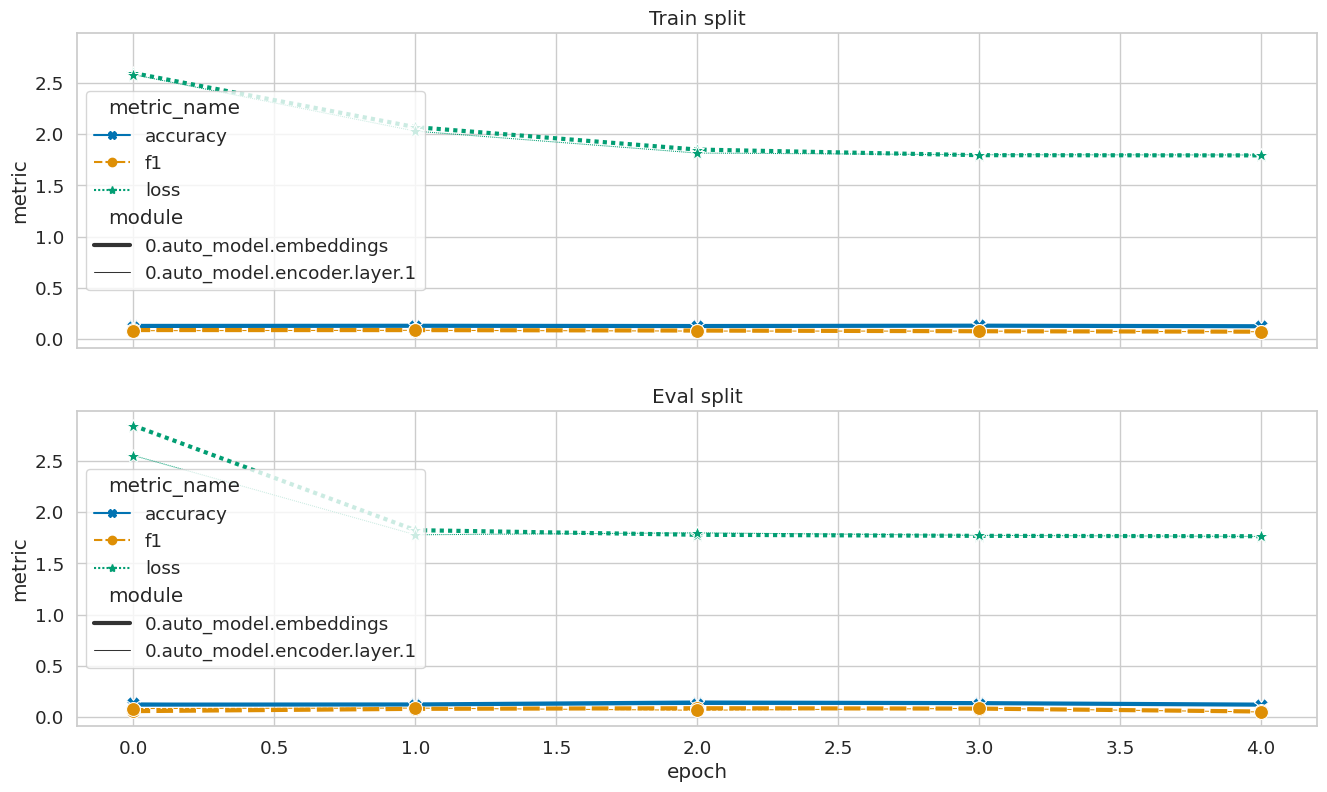

In [65]:
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.2,
    palette="colorblind",
)

fig, (ax_train, ax_eval) = plt.subplots(2, figsize=(16, 9), sharey=True, sharex=True)

df_train, df_eval, df_test = probing_results.to_pandas(aggregate_by=["batch_index"])

common_kwargs = dict(
    hue="metric_name",
    y="metric",
    x="epoch",
    size="module",
    style="metric_name",
    markers=["X", "o", "*"],
    markersize=10,
    size_order=["0.auto_model.embeddings", "0.auto_model.encoder.layer.1"],
)

sns.lineplot(data=df_train, ax=ax_train, **common_kwargs)
sns.lineplot(data=df_eval, ax=ax_eval, **common_kwargs)

ax_train.set_title("Train split")
ax_eval.set_title("Eval split")

plt.show();

In [66]:
df_test

,epoch,metric_name,module,metric
0,-1,accuracy,0.auto_model.embeddings,0.135471
1,-1,accuracy,0.auto_model.encoder.layer.1,0.129426
2,-1,f1,0.auto_model.embeddings,0.067570
3,-1,f1,0.auto_model.encoder.layer.1,0.054222
4,-1,loss,0.auto_model.embeddings,1.770834
5,-1,loss,0.auto_model.encoder.layer.1,1.772244
